<a href="https://colab.research.google.com/github/Chekuriakhilvarma/Project_Code/blob/main/DualBranchCNN_Mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Code to access this dataset from google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

# Dataset path
indoor_dataset_dir = '/content/drive/MyDrive/Dataset/train'
indoor_test_dir = '/content/drive/MyDrive/Dataset/test'


In [3]:
# Install packages needed
!pip install -U keras-cv split-folders
# Import the libraries needed for this dissertation
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
# TensorFlow / Keras for model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, Input
from tensorflow.keras.models import Model
# InceptionV3 used as the CNN feature extraction branch
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# Used for loading and augmenting the indoor scene image dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Training helpers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Vision Transformer (ViT) model from KerasCV (legacy namespace)
import keras_cv
from keras_cv.src.models.legacy import ViTTiny16
# Metrics for evaluation and confusion matrix generation
from sklearn.metrics import (confusion_matrix,ConfusionMatrixDisplay,classification_report)
# Utility for splitting dataset folders into train/val/test sets
import splitfolders
# Reduce TensorFlow log noise and ignore warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 55.0 MB/s eta 0:00:00


In [4]:
# Split the indoor scene dataset into training and validation subsets
splitfolders.ratio(indoor_dataset_dir,output="/content/IndoorScene_Split",seed=24000105,
    ratio=(0.70, 0.30),move=False)
# Directories for the resulting training and validation subsets
indoor_train_dir = "/content/IndoorScene_Split/train"
indoor_val_dir   = "/content/IndoorScene_Split/val"

Copying files: 3981 files [06:44,  9.85 files/s] 


In [5]:
# Image resolution used for all indoor scene classification models
indoor_image_size = (299, 299)
# Number of images processed per batch during training and validation
indoor_batch_size = 32
# Data augmentation applied to the indoor scene training images
indoor_train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
# Generator for indoor scene validation images without augmentation
indoor_val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
# Loads the indoor scene training samples
indoor_train_loader = indoor_train_data_generator.flow_from_directory(
    indoor_train_dir,
    target_size=indoor_image_size,
    batch_size=indoor_batch_size,
    class_mode='categorical',
    shuffle=True)
# Loads the indoor scene validation samples
indoor_val_loader = indoor_val_data_generator.flow_from_directory(
    indoor_val_dir,
    target_size=indoor_image_size,
    batch_size=indoor_batch_size,
    class_mode='categorical',
    shuffle=False)
# Number of indoor scene categories
num_scene_classes = indoor_train_loader.num_classes
# Names of the indoor scene classes
scene_class_labels = list(indoor_train_loader.class_indices.keys())

Found 2777 images belonging to 15 classes.
Found 1204 images belonging to 15 classes.


In [6]:
# Input layer for the dual-branch indoor scene model
indoor_dual_input = Input(shape=(indoor_image_size[0], indoor_image_size[1], 3))
# Global feature branch using a frozen InceptionV3 backbone
inception_global_branch = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(indoor_image_size[0], indoor_image_size[1], 3))
inception_global_branch.trainable = False
global_scene_features = inception_global_branch(indoor_dual_input)
global_scene_features = layers.GlobalAveragePooling2D()(global_scene_features)
# Local feature branch using a shallow custom CNN
local_scene_features = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(indoor_dual_input)
local_scene_features = layers.MaxPooling2D(pool_size=(2, 2))(local_scene_features)
local_scene_features = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(local_scene_features)
local_scene_features = layers.GlobalAveragePooling2D()(local_scene_features)
# Fusion of global and local indoor scene features
fused_scene_features = layers.concatenate([global_scene_features, local_scene_features])
# Fully connected classification head for indoor scene categories
fused_scene_features = layers.Dense(512, activation='relu')(fused_scene_features)
fused_scene_features = layers.Dropout(0.5)(fused_scene_features)
dual_branch_scene_predictions = layers.Dense(num_scene_classes, activation='softmax')(fused_scene_features)
# Dual-branch indoor scene classification model
indoor_dual_branch_model = models.Model(
    inputs=indoor_dual_input,
    outputs=dual_branch_scene_predictions)
# Compile the dual-branch model
indoor_dual_branch_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [7]:
# Early stopping for dual-branch indoor scene training
dual_branch_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)
# Checkpoint to save the best dual-branch indoor scene model
dual_branch_checkpoint = ModelCheckpoint(
    'dual_branch_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1)
# Train the dual-branch indoor scene classification model
dual_branch_training_history = indoor_dual_branch_model.fit(
    indoor_train_loader,
    validation_data=indoor_val_loader,
    epochs=10,
    callbacks=[dual_branch_early_stop, dual_branch_checkpoint],
    verbose=1)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3302 - loss: 2.2406
Epoch 1: val_accuracy improved from -inf to 0.72508, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.3318 - loss: 2.2363 - val_accuracy: 0.7251 - val_loss: 1.0980
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.6546 - loss: 1.2643
Epoch 2: val_accuracy improved from 0.72508 to 0.77824, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 78s 895ms/step - accuracy: 0.6547 - loss: 1.2632 - val_accuracy: 0.7782 - val_loss: 0.7538
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.7310 - loss: 0.9273
Epoch 3: val_accuracy improved from 0.77824 to 0.82475, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 81s 931ms/step - accuracy: 0.7310 - loss: 0.9271 - val_accuracy: 0.8248 - val_loss: 0.6240
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.7612 - loss: 0.8141
Epoch 4: val_accuracy improved from 0.82475 to 0.83472, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 925ms/step - accuracy: 0.7613 - loss: 0.8137 - val_accuracy: 0.8347 - val_loss: 0.5656
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.7600 - loss: 0.7690
Epoch 5: val_accuracy improved from 0.83472 to 0.83970, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 923ms/step - accuracy: 0.7601 - loss: 0.7688 - val_accuracy: 0.8397 - val_loss: 0.5380
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.7809 - loss: 0.7011
Epoch 6: val_accuracy improved from 0.83970 to 0.86047, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 910ms/step - accuracy: 0.7810 - loss: 0.7008 - val_accuracy: 0.8605 - val_loss: 0.4858
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.7942 - loss: 0.6885
Epoch 7: val_accuracy did not improve from 0.86047
87/87 ━━━━━━━━━━━━━━━━━━━━ 78s 899ms/step - accuracy: 0.7942 - loss: 0.6882 - val_accuracy: 0.8488 - val_loss: 0.4835
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.8123 - loss: 0.6084
Epoch 8: val_accuracy did not improve from 0.86047
87/87 ━━━━━━━━━━━━━━━━━━━━ 77s 891ms/step - accuracy: 0.8124 - loss: 0.6086 - val_accuracy: 0.8563 - val_loss: 0.4619
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.8103 - loss: 0.6016
Epoch 9: val_accuracy improved from 0.86047 to 0.86545, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 909ms/step - accuracy: 0.8102 - loss: 0.6016 - val_accuracy: 0.8654 - val_loss: 0.4418
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.8359 - loss: 0.5487
Epoch 10: val_accuracy improved from 0.86545 to 0.86877, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 913ms/step - accuracy: 0.8357 - loss: 0.5487 - val_accuracy: 0.8688 - val_loss: 0.4319


In [8]:
# Reset the validation loader to ensure consistent prediction order
indoor_val_loader.reset()
# Generate class probability predictions using the dual-branch indoor scene model
dual_branch_val_predictions = indoor_dual_branch_model.predict(indoor_val_loader, verbose=1)
# Convert probabilities to predicted class indices
dual_branch_val_predicted_labels = np.argmax(dual_branch_val_predictions, axis=1)
# True indoor scene class labels from the validation set
dual_branch_val_true_labels = indoor_val_loader.classes
# Indoor scene category names
dual_branch_scene_class_labels = list(indoor_val_loader.class_indices.keys())

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step


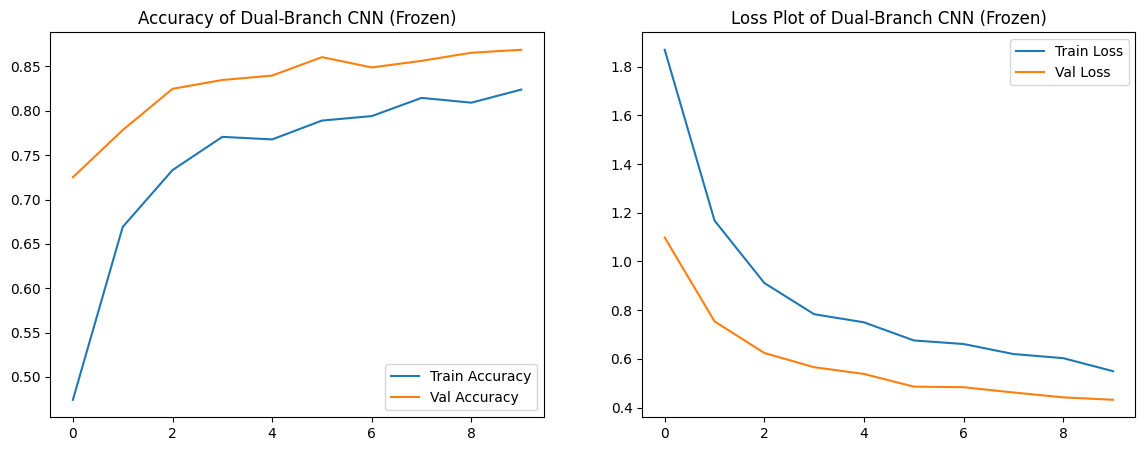

In [9]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(dual_branch_training_history.history['accuracy'], label='Train Accuracy')
plt.plot(dual_branch_training_history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy of Dual-Branch CNN (Frozen)")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(dual_branch_training_history.history['loss'], label='Train Loss')
plt.plot(dual_branch_training_history.history['val_loss'], label='Val Loss')
plt.title("Loss Plot of Dual-Branch CNN (Frozen)")
plt.legend()
plt.show()

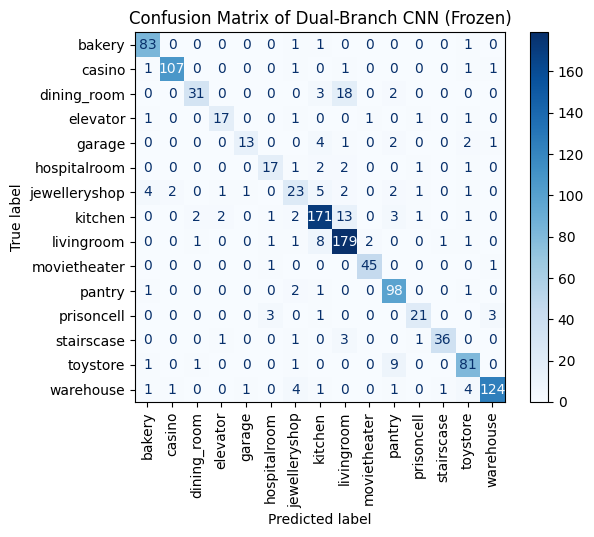

In [10]:
# Compute the confusion matrix for the dual-branch indoor scene model
dual_branch_confusion_mat = confusion_matrix(
    dual_branch_val_true_labels,
    dual_branch_val_predicted_labels)
# Display the confusion matrix using indoor scene class labels
dual_branch_confusion_display = ConfusionMatrixDisplay(
    confusion_matrix=dual_branch_confusion_mat,
    display_labels=dual_branch_scene_class_labels)
dual_branch_confusion_display.plot(
    xticks_rotation='vertical',
    cmap='Blues')
plt.title("Confusion Matrix of Dual-Branch CNN (Frozen)")
plt.show()


In [11]:
# Generate a detailed classification report for the dual-branch indoor scene model
dual_branch_classification_report = classification_report(
    dual_branch_val_true_labels,
    dual_branch_val_predicted_labels,
    target_names=dual_branch_scene_class_labels)
print("Classification Report of Dual-Branch CNN (Frozen):\n")
print(dual_branch_classification_report)

Classification Report of Dual-Branch CNN (Frozen):

               precision    recall  f1-score   support

       bakery       0.90      0.97      0.93        86
       casino       0.97      0.96      0.96       112
  dining_room       0.89      0.57      0.70        54
     elevator       0.81      0.77      0.79        22
       garage       0.87      0.57      0.68        23
 hospitalroom       0.74      0.71      0.72        24
jewelleryshop       0.61      0.55      0.57        42
      kitchen       0.87      0.87      0.87       196
   livingroom       0.82      0.92      0.87       194
 movietheater       0.94      0.96      0.95        47
       pantry       0.84      0.95      0.89       103
   prisoncell       0.81      0.75      0.78        28
   stairscase       0.95      0.86      0.90        42
     toystore       0.85      0.87      0.86        93
    warehouse       0.95      0.90      0.93       138

     accuracy                           0.87      1204
    macro a

In [12]:
# Input layer for the dual-branch indoor scene model
indoor_dual_input = Input(shape=(indoor_image_size[0], indoor_image_size[1], 3))

# Load pretrained InceptionV3 backbone
inception_global_branch = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(indoor_image_size[0], indoor_image_size[1], 3)
)

# 1. Freeze ALL layers first (transfer learning phase)
for layer in inception_global_branch.layers:
    layer.trainable = False

# 2. Fine-tune deeper layers (InceptionV3 has ~311 layers; last 60–80 is standard)
for layer in inception_global_branch.layers[-70:]:
    layer.trainable = True

# Extract global scene features
global_scene_features = inception_global_branch(indoor_dual_input)
global_scene_features = layers.GlobalAveragePooling2D()(global_scene_features)
local_scene_features = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(indoor_dual_input)
local_scene_features = layers.MaxPooling2D(pool_size=(2, 2))(local_scene_features)
local_scene_features = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(local_scene_features)
local_scene_features = layers.GlobalAveragePooling2D()(local_scene_features)

fused_scene_features = layers.concatenate([global_scene_features, local_scene_features])
fused_scene_features = layers.Dense(512, activation='relu')(fused_scene_features)
fused_scene_features = layers.Dropout(0.5)(fused_scene_features)

dual_branch_scene_predictions = layers.Dense(num_scene_classes, activation='softmax')(fused_scene_features)

indoor_dual_finetune_model = models.Model(
    inputs=indoor_dual_input,
    outputs=dual_branch_scene_predictions
)


indoor_dual_finetune_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
# Train the dual-branch indoor scene classification model
dual_branch_finetune_history = indoor_dual_finetune_model.fit(
    indoor_train_loader,
    validation_data=indoor_val_loader,
    epochs=10,
    callbacks=[dual_branch_early_stop, dual_branch_checkpoint],
    verbose=1)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.4581 - loss: 1.8164
Epoch 1: val_accuracy did not improve from 0.86877
87/87 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.4599 - loss: 1.8108 - val_accuracy: 0.7957 - val_loss: 0.6585
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.8193 - loss: 0.6029
Epoch 2: val_accuracy did not improve from 0.86877
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 908ms/step - accuracy: 0.8193 - loss: 0.6027 - val_accuracy: 0.8671 - val_loss: 0.4309
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.8782 - loss: 0.3979
Epoch 3: val_accuracy improved from 0.86877 to 0.89452, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 915ms/step - accuracy: 0.8782 - loss: 0.3978 - val_accuracy: 0.8945 - val_loss: 0.3436
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.9119 - loss: 0.3167
Epoch 4: val_accuracy improved from 0.89452 to 0.89867, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 924ms/step - accuracy: 0.9119 - loss: 0.3167 - val_accuracy: 0.8987 - val_loss: 0.3328
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9366 - loss: 0.2059
Epoch 5: val_accuracy did not improve from 0.89867
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 914ms/step - accuracy: 0.9365 - loss: 0.2060 - val_accuracy: 0.8929 - val_loss: 0.3291
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.9555 - loss: 0.1571
Epoch 6: val_accuracy improved from 0.89867 to 0.90365, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 84s 963ms/step - accuracy: 0.9554 - loss: 0.1572 - val_accuracy: 0.9037 - val_loss: 0.3388
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.9597 - loss: 0.1451
Epoch 7: val_accuracy did not improve from 0.90365
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 915ms/step - accuracy: 0.9597 - loss: 0.1452 - val_accuracy: 0.8846 - val_loss: 0.3792
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.9611 - loss: 0.1276
Epoch 8: val_accuracy improved from 0.90365 to 0.90698, saving model to dual_branch_best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 81s 926ms/step - accuracy: 0.9611 - loss: 0.1277 - val_accuracy: 0.9070 - val_loss: 0.3186
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.9698 - loss: 0.0971
Epoch 9: val_accuracy did not improve from 0.90698
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 912ms/step - accuracy: 0.9697 - loss: 0.0972 - val_accuracy: 0.8970 - val_loss: 0.3951
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.9708 - loss: 0.0945
Epoch 10: val_accuracy did not improve from 0.90698
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 911ms/step - accuracy: 0.9709 - loss: 0.0944 - val_accuracy: 0.8978 - val_loss: 0.3903


In [14]:
# Reset the validation loader to ensure consistent prediction order
indoor_val_loader.reset()
# Generate class probability predictions using the dual-branch indoor scene model
dual_fine_val_predictions = indoor_dual_finetune_model.predict(indoor_val_loader, verbose=1)
# Convert probabilities to predicted class indices
dual_fine_val_predicted_labels = np.argmax(dual_fine_val_predictions, axis=1)
# True indoor scene class labels from the validation set
dual_fine_val_true_labels = indoor_val_loader.classes
# Indoor scene category names
dual_branch_scene_class_labels = list(indoor_val_loader.class_indices.keys())

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step


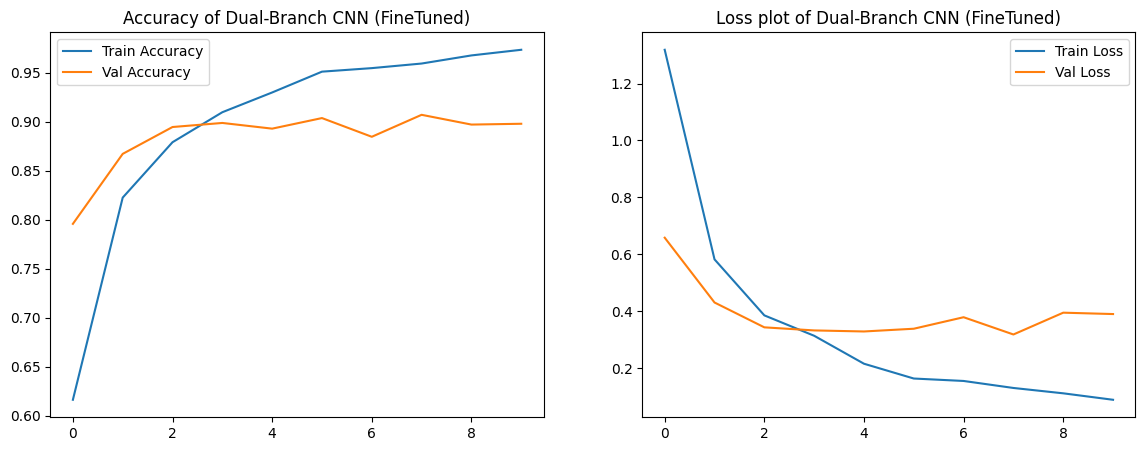

In [15]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(dual_branch_finetune_history.history['accuracy'], label='Train Accuracy')
plt.plot(dual_branch_finetune_history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy of Dual-Branch CNN (FineTuned)")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(dual_branch_finetune_history.history['loss'], label='Train Loss')
plt.plot(dual_branch_finetune_history.history['val_loss'], label='Val Loss')
plt.title("Loss plot of Dual-Branch CNN (FineTuned)")
plt.legend()
plt.show()

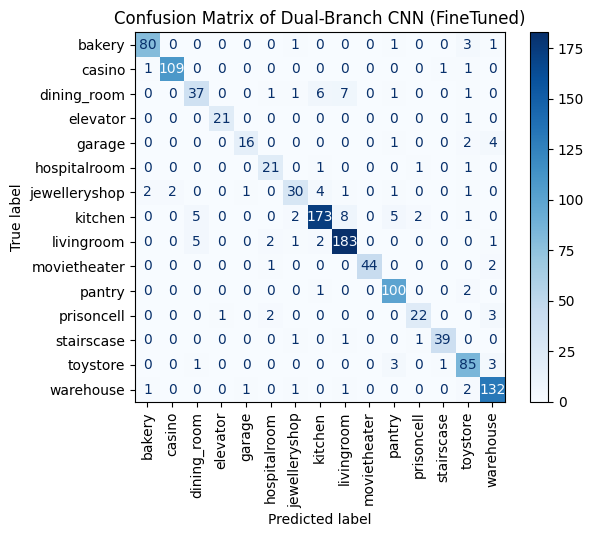

In [16]:
# Compute the confusion matrix for the dual-branch indoor scene model
dual_fine_confusion_mat = confusion_matrix(
    dual_fine_val_true_labels,
    dual_fine_val_predicted_labels)
# Display the confusion matrix using indoor scene class labels
dual_fine_confusion_display = ConfusionMatrixDisplay(
    confusion_matrix=dual_fine_confusion_mat,
    display_labels=dual_branch_scene_class_labels)
dual_fine_confusion_display.plot(
    xticks_rotation='vertical',
    cmap='Blues')
plt.title("Confusion Matrix of Dual-Branch CNN (FineTuned)")
plt.show()


In [17]:
# Generate a detailed classification report for the dual-branch indoor scene model
dual_fine_classification_report = classification_report(
    dual_fine_val_true_labels,
    dual_fine_val_predicted_labels,
    target_names=dual_branch_scene_class_labels)
print("Classification Report of Dual-Branch CNN (FineTuned):\n")
print(dual_fine_classification_report)

Classification Report of Dual-Branch CNN (FineTuned):

               precision    recall  f1-score   support

       bakery       0.95      0.93      0.94        86
       casino       0.98      0.97      0.98       112
  dining_room       0.77      0.69      0.73        54
     elevator       0.95      0.95      0.95        22
       garage       0.89      0.70      0.78        23
 hospitalroom       0.78      0.88      0.82        24
jewelleryshop       0.81      0.71      0.76        42
      kitchen       0.93      0.88      0.90       196
   livingroom       0.91      0.94      0.93       194
 movietheater       1.00      0.94      0.97        47
       pantry       0.89      0.97      0.93       103
   prisoncell       0.85      0.79      0.81        28
   stairscase       0.95      0.93      0.94        42
     toystore       0.85      0.91      0.88        93
    warehouse       0.90      0.96      0.93       138

     accuracy                           0.91      1204
    macr

Found 766 images belonging to 15 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.8781 - loss: 0.3939
Dual-Branch Test Accuracy: 0.8759791254997253
Dual-Branch Test Loss: 0.4172334671020508
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 534ms/step


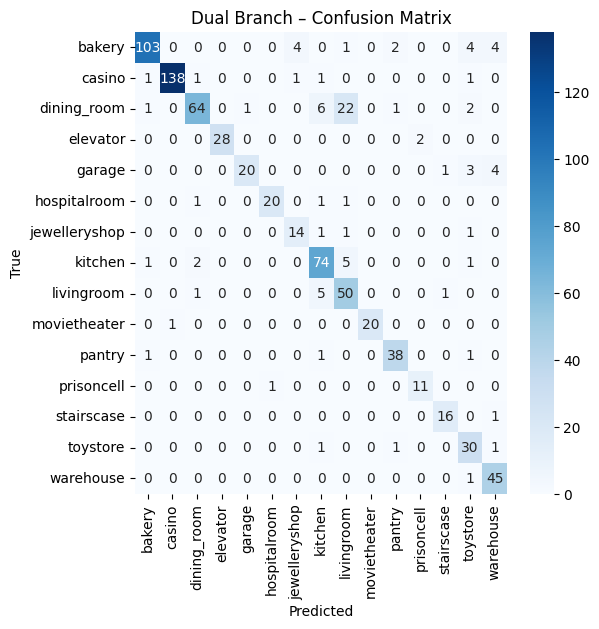

               precision    recall  f1-score   support

       bakery       0.96      0.87      0.92       118
       casino       0.99      0.97      0.98       143
  dining_room       0.93      0.66      0.77        97
     elevator       1.00      0.93      0.97        30
       garage       0.95      0.71      0.82        28
 hospitalroom       0.95      0.87      0.91        23
jewelleryshop       0.74      0.82      0.78        17
      kitchen       0.82      0.89      0.86        83
   livingroom       0.62      0.88      0.73        57
 movietheater       1.00      0.95      0.98        21
       pantry       0.90      0.93      0.92        41
   prisoncell       0.85      0.92      0.88        12
   stairscase       0.89      0.94      0.91        17
     toystore       0.68      0.91      0.78        33
    warehouse       0.82      0.98      0.89        46

     accuracy                           0.88       766
    macro avg       0.87      0.88      0.87       766
 weighte

In [21]:
indoor_test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

indoor_test_loader = indoor_test_data_generator.flow_from_directory(
    indoor_test_dir,
    target_size=indoor_image_size,
    batch_size=indoor_batch_size,
    class_mode='categorical',
    shuffle=False
)

best_dual_branch_model = keras.models.load_model(
    "dual_branch_best_model.h5",
    compile=False
)

best_dual_branch_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

dual_test_loss, dual_test_acc = best_dual_branch_model.evaluate(
    indoor_test_loader, verbose=1
)

print("Dual-Branch Test Accuracy:", dual_test_acc)
print("Dual-Branch Test Loss:", dual_test_loss)

indoor_test_loader.reset()
dual_preds = best_dual_branch_model.predict(indoor_test_loader)
dual_pred_labels = np.argmax(dual_preds, axis=1)
dual_true_labels = indoor_test_loader.classes

cm2 = confusion_matrix(dual_true_labels, dual_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm2,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(indoor_test_loader.class_indices.keys()),
    yticklabels=list(indoor_test_loader.class_indices.keys())
)
plt.title("Dual Branch – Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

print(classification_report(
    dual_true_labels,
    dual_pred_labels,
    target_names=list(indoor_test_loader.class_indices.keys())
))


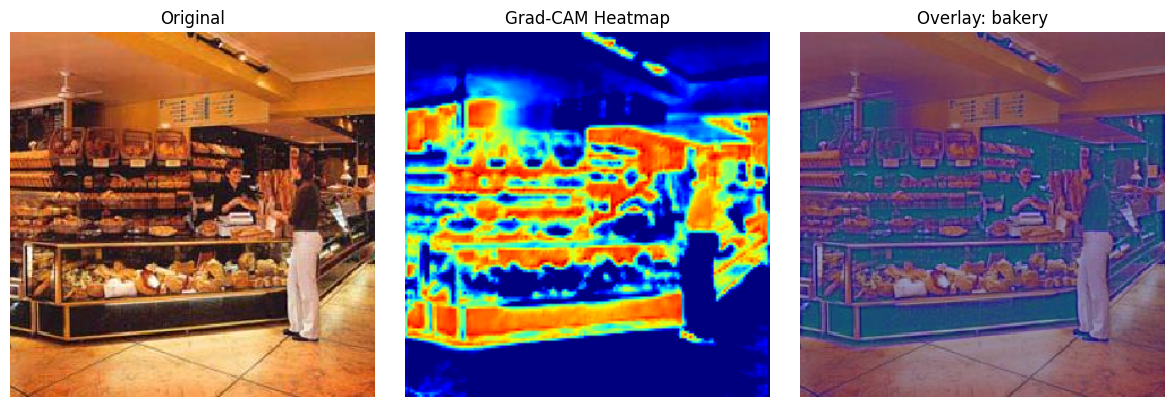

In [24]:

# GRAD-CAM FOR DUAL-BRANCH CNN (LOCAL BRANCH)

import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Function to load and preprocess an image for the dual-branch model
def preprocess_dual(img_path, target_size=indoor_image_size):
    # Load image from disk
    img = keras.preprocessing.image.load_img(img_path, target_size=target_size)
    # Convert to array
    arr = keras.preprocessing.image.img_to_array(img)
    # Copy for display in [0,1]
    arr_display = arr.astype("float32") / 255.0
    # Apply InceptionV3 preprocessing for the model input
    arr_model = preprocess_input(arr.copy())
    # Add batch dimension
    arr_model = np.expand_dims(arr_model, axis=0)
    return arr_display, arr_model

# Grad-CAM function using the last conv layer of the local CNN branch
def gradcam_dual_local(image_tensor, model, last_conv_layer_name="conv2d_191"):
    # Get the last convolution layer of the local branch
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Build a model that gives feature maps and final predictions
    grad_model = tf.keras.models.Model(
        [model.input],
        [last_conv_layer.output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_tensor)
        # Index of the predicted class
        predicted_index = tf.argmax(predictions[0])
        # Score of the predicted class
        class_score = predictions[:, predicted_index]

    # Compute gradients of the class score with respect to conv feature maps
    grads = tape.gradient(class_score, conv_outputs)

    # Global average pooling over the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Remove batch dimension from conv outputs
    conv_outputs = conv_outputs[0]

    # Weight each channel by its importance
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Apply ReLU
    heatmap = tf.nn.relu(heatmap)

    # Normalize to [0,1]
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy(), int(predicted_index.numpy())

# Function to overlay the Grad-CAM heatmap onto the original image
def overlay_dual(img_display, heatmap, alpha=0.4):
    # Convert display image to uint8
    img_uint8 = (img_display * 255).astype("uint8")
    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
    # Apply color map
    heat_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    # Convert RGB to BGR for blending
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
    # Blend original image with heatmap
    blended_bgr = cv2.addWeighted(img_bgr, 1 - alpha, heat_color, alpha, 0)
    # Convert back to RGB for plotting
    blended_rgb = cv2.cvtColor(blended_bgr, cv2.COLOR_BGR2RGB)
    return blended_rgb

# Choose an index from the test loader
test_index = 0

# Get the image path
test_path = indoor_test_loader.filepaths[test_index]

# Preprocess image for display and model
img_show, img_model = preprocess_dual(test_path)

# Compute Grad-CAM heatmap and predicted class index
heatmap, idx = gradcam_dual_local(img_model, best_dual_branch_model)

# Map class index to class name
class_names = list(indoor_test_loader.class_indices.keys())
pred_name = class_names[idx]

# Create overlay image
overlay_img = overlay_dual(img_show, heatmap)

# Plot original, heatmap, and overlay
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_show)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Overlay: {pred_name}")
plt.imshow(overlay_img)
plt.axis("off")

plt.tight_layout()
plt.show()
